# This notebook is used to tread the data from the scrips of jvm-comp

In [1]:
from itertools import islice
import pandas as pd
import numpy as np
from scipy import stats
from  qgrid import show_grid as show 
import plotly.express as px
import math
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
pd.options.plotting.backend ='matplotlib'

# mpl.rcParams['boxplot.boxprops.color'] ='red'

# mpl.rcParams['boxplot.boxprops.linewidth']=2
# mpl.rcParams['patch.edgecolor']='black'

# mpl.rcParams['boxplot.patchartist']= "True"
# mpl.rcParams['boxplot.flierprops.marker'] = 'o'
# mpl.rcParams['boxplot.flierprops.color'] = 'k'
# mpl.rcParams['boxplot.flierprops.markerfacecolor'] = "white"
# mpl.rcParams['boxplot.medianprops.color'] = 'red'
#### axes 
mpl.rcParams['axes.titlesize'] = 30 
mpl.rcParams['axes.titlepad'] = 50 
mpl.rcParams['axes.labelsize']=30
mpl.rcParams['axes.labelpad']=20
mpl.rcParams['xtick.labelsize']= 25
mpl.rcParams['ytick.labelsize']= 25
mpl.rcParams['axes.grid']= True

# labelpad
# mpl.rc('axes',titlesize= 30)

# mpl.rc('xtick', labelsize=22) 
# mpl.rc('ytick', labelsize=22) 
mpl.rcParams['text.usetex'] = True

## Plotting the power graphs 

used to post process the files generated by `recordpower.sh`

### Retrieving Data

In [30]:

def parse_log(file_name):

    def slice_log(lines,i,offset=16):
        l=list(islice(lines,i*offset,(i+1)*offset))
        x={}
        x["name"]=l[1]
        x["jvm"],x["benchmark"],x["iteration"]=l[1].strip().split("_")
        x['iteration']=int(x['iteration'])
        x["begin"]=int(l[2])
        x["CPU"]=float(l[8].strip().split(" ")[0].replace(",",""))*1000000
#         x["energy_core"]=float(l[9].strip().split(" ")[0].replace(",",""))
        x["DRAM"]=float(l[10].strip().split(" ")[0].replace(",",""))*1000000
        x["duration"]=float(l[13].strip().split(" ")[0].replace(",",""))*1000000
#         x["av_power_pkg"]=x["energy_pkg"]/x["execution_time"]
        x["end"]=int(l[15])
        return x
    
    with open(file_name,'r') as f :
        x=f.readline()
        offset=1
        for line in f.readlines(): 
            if line == x : 
                break 
            offset=offset+1
        f.seek(0)
        lines = f.readlines()
        limit=len(lines)//offset
        l=[slice_log(lines,i,offset) for i in range(0,limit)]
        data=pd.DataFrame(l)
        return data


def read_powers(file):
    periode=5
    powers=pd.read_csv(file,
                   usecols=["timestamp","socket","cpu","RAPL_ENERGY_DRAM","RAPL_ENERGY_PKG"],
                  )
    powers["CPU"]=powers["RAPL_ENERGY_PKG"].apply(lambda x : math.ldexp(x,-32)/periode)
    powers["DRAM"]=powers["RAPL_ENERGY_DRAM"].apply(lambda x : math.ldexp(x,-32)/periode)
    powers=powers.loc[powers["cpu"]<=1].drop(columns=["socket","cpu","RAPL_ENERGY_PKG","RAPL_ENERGY_DRAM"]).reset_index()
    powers=powers.groupby("timestamp").sum().reset_index()
    return powers

def get_test(timestamp,df):
    x=df.loc[np.logical_and(df["begin"]<=timestamp,df["end"]>=timestamp)]["name"]
    if len(x) == 1  :
        return x.iloc[0].strip() 
    return "nothing_nothing_0"


def get_relative_ts(timestamp,df):
    x=df.loc[np.logical_and(df["begin"]<=timestamp,df["end"]>=timestamp)]["begin"]
    if len(x) == 1  :
        return timestamp-x.iloc[0] 
    return 0

def parse_powers(logfile,powersfile):
    df=parse_log(logfile)
    powers=read_powers(powersfile)
    powers["name"] = powers["timestamp"].apply(lambda x :get_test(x/1000,df))
    powers[["jvm","benchmark","iteration"]]=powers["name"].str.split("_",expand=True)
    powers["relative_ts"]=powers["timestamp"].apply(lambda x :get_relative_ts(x/1000,df))
    
    return powers.sort_values("relative_ts")
    


### Ploting function

In [3]:

colors={"15.0.1.j9-adpt":"#3498DB",
       "20.2.0.r11-grl":"#16A085",
       "15.0.1-open":"#F0B27A"}


def plot_powers(data2,axes):
    for i in data2["jvm"].unique() : 
        x= data2.loc[data2["jvm"]==i]
        axes.plot(x["relative_ts"],x["DRAM"],label=i,color=colors[i])
    
    axes.legend(fontsize=25,loc='center left', bbox_to_anchor=(1.0, 0.5),)
    axes.grid("True" )
    axes.set_ylabel(ylabel="Average Power (W)")
    axes.set_xlabel(xlabel="Time (s) ")
    legends=[
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='HotSpot',
                          markerfacecolor='#F0B27A', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='J9',
                          markerfacecolor='#3498DB', markersize=30),
            ]

    axes.legend(handles=legends ,fontsize='25',labelspacing=1,loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.subplots_adjust(right=0.8)
    plt.xlim([-20, 1200])
    plt.tight_layout()
    return axes


In [36]:
data=parse_powers("report.logs","powers.csv")
data=data.loc[data["iteration"]=="1"]
data=data.loc[data["benchmark"]!="philosopher"]

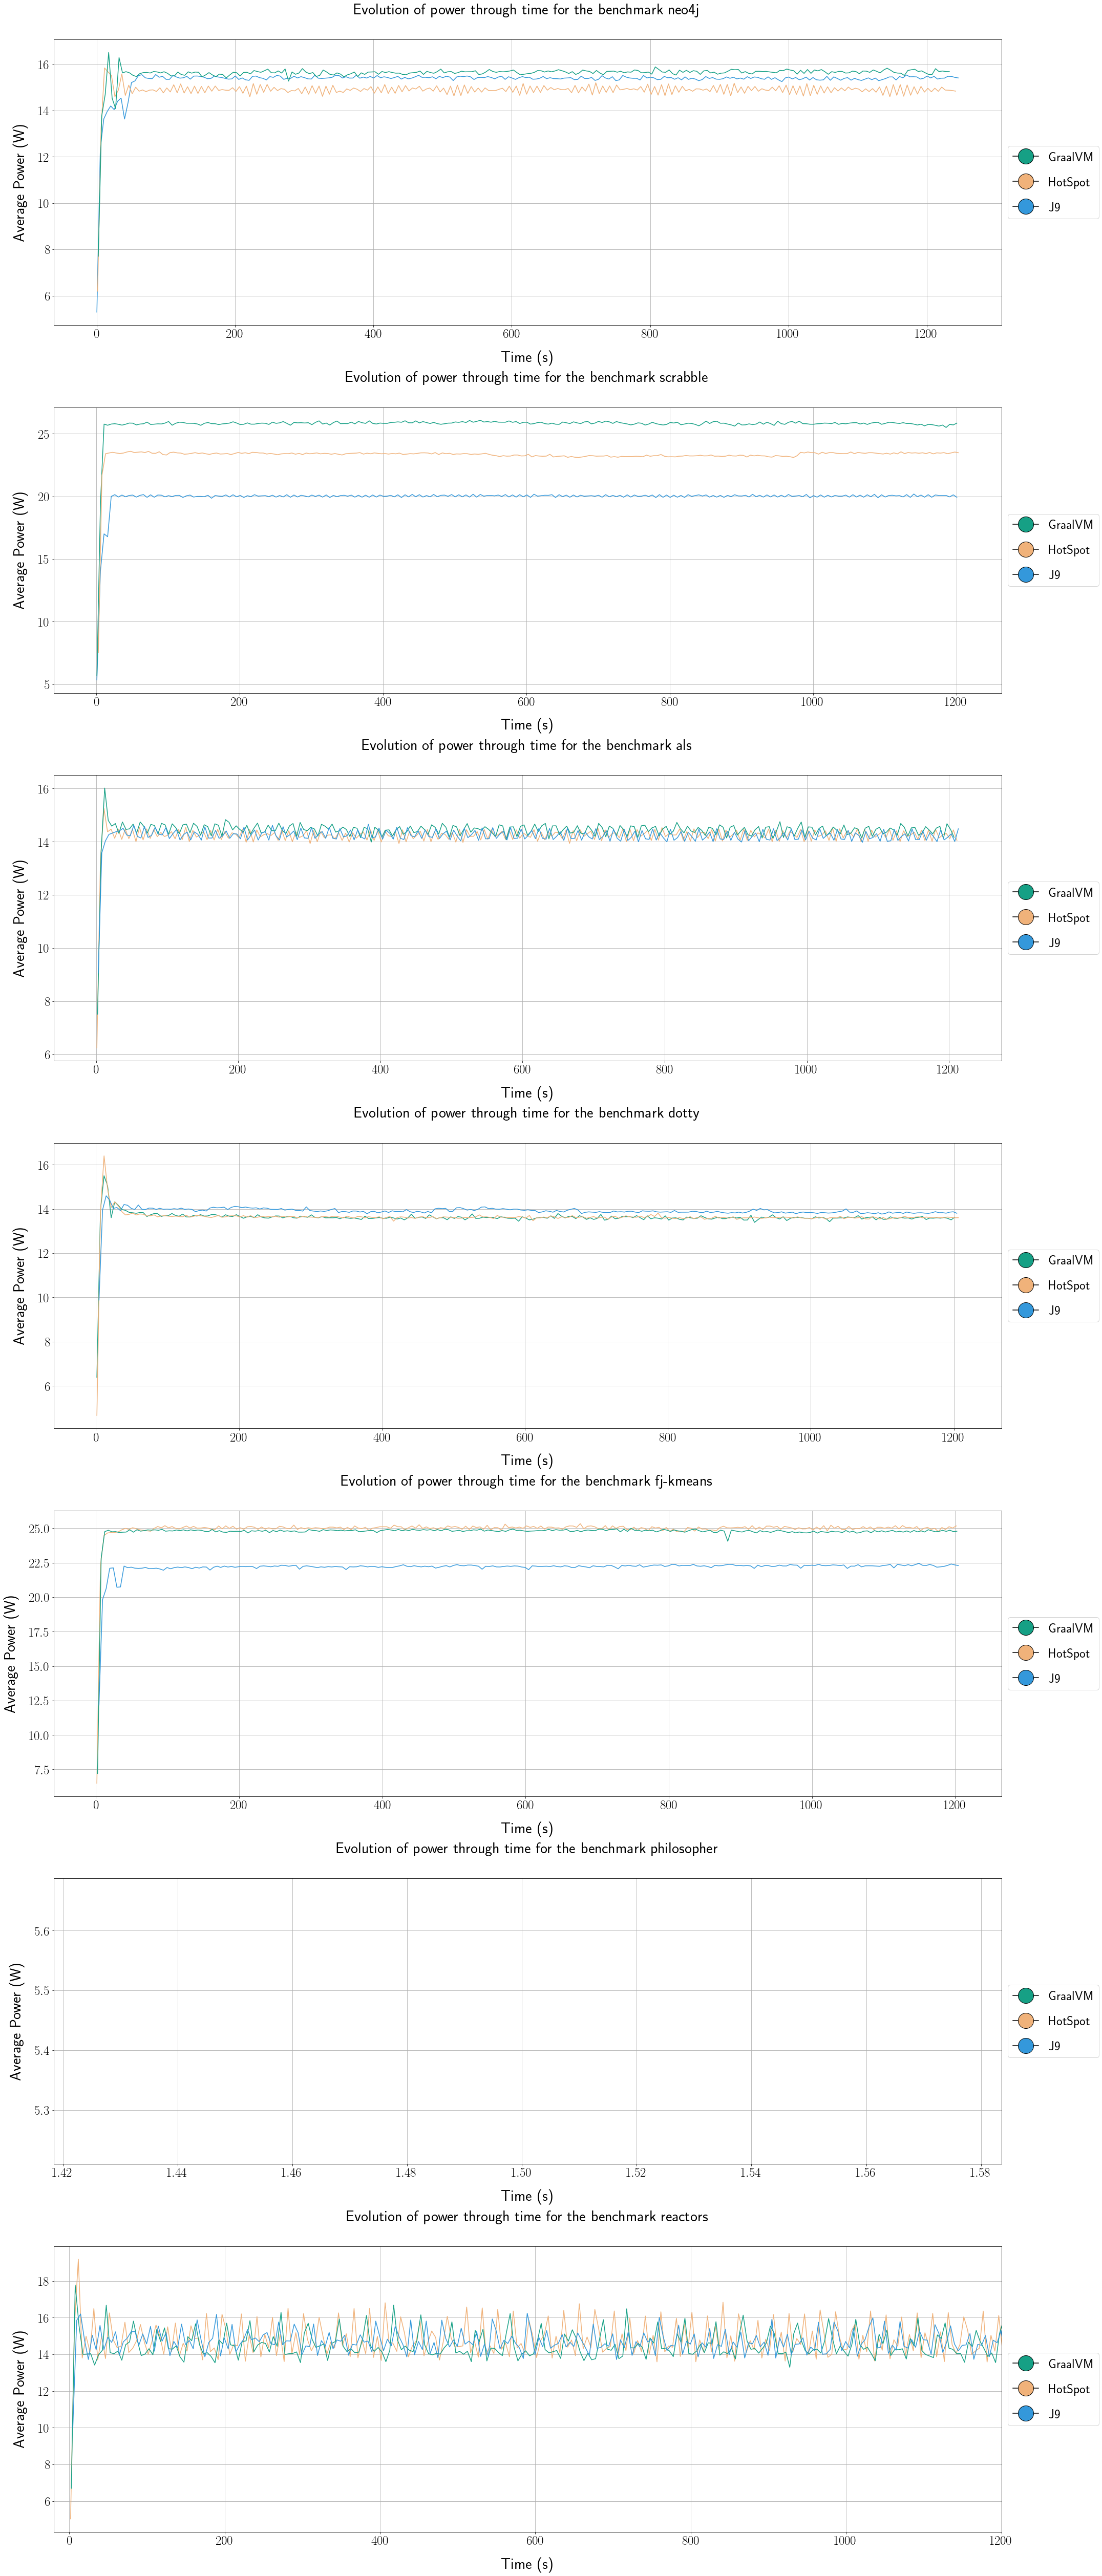

In [38]:
benchmarks=list(data.benchmark.unique())
fig,axes = plt.subplots(7,1, figsize=(30, 10*len(benchmarks)))
i=0
for bench in benchmarks : 
    plot_powers(data.loc[data["benchmark"]==bench],axes[i])
    axes[i].set_title(f"Evolution of power through time for the benchmark {bench}"  )
    i+=1
    



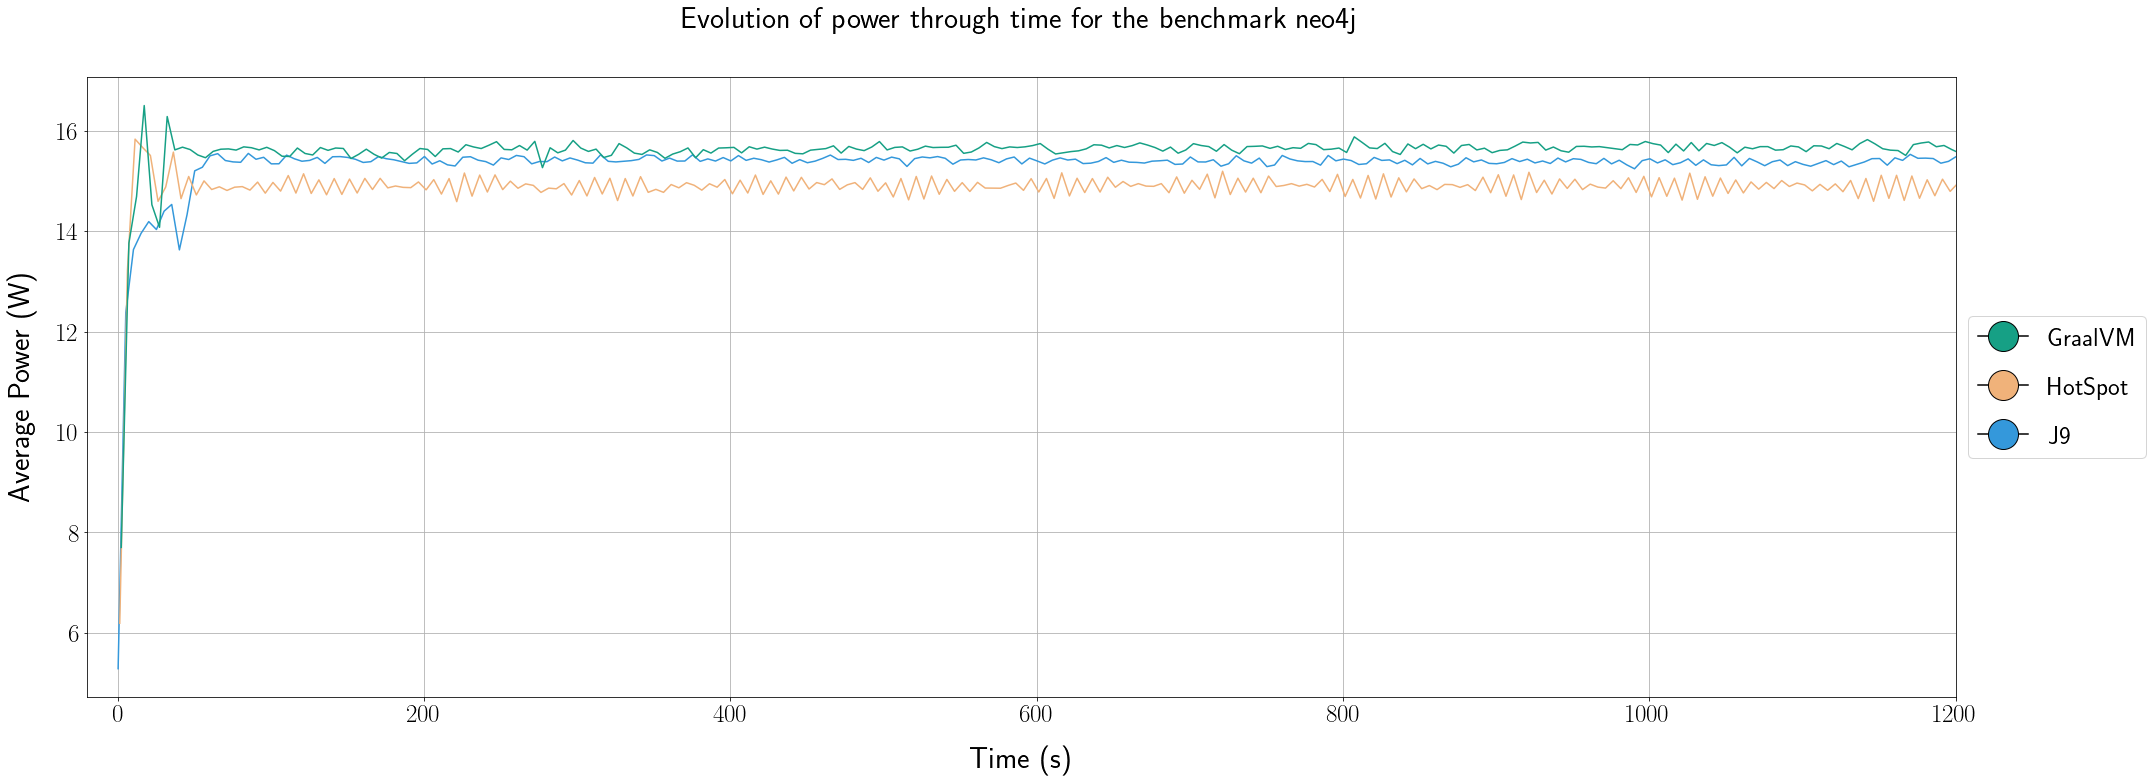

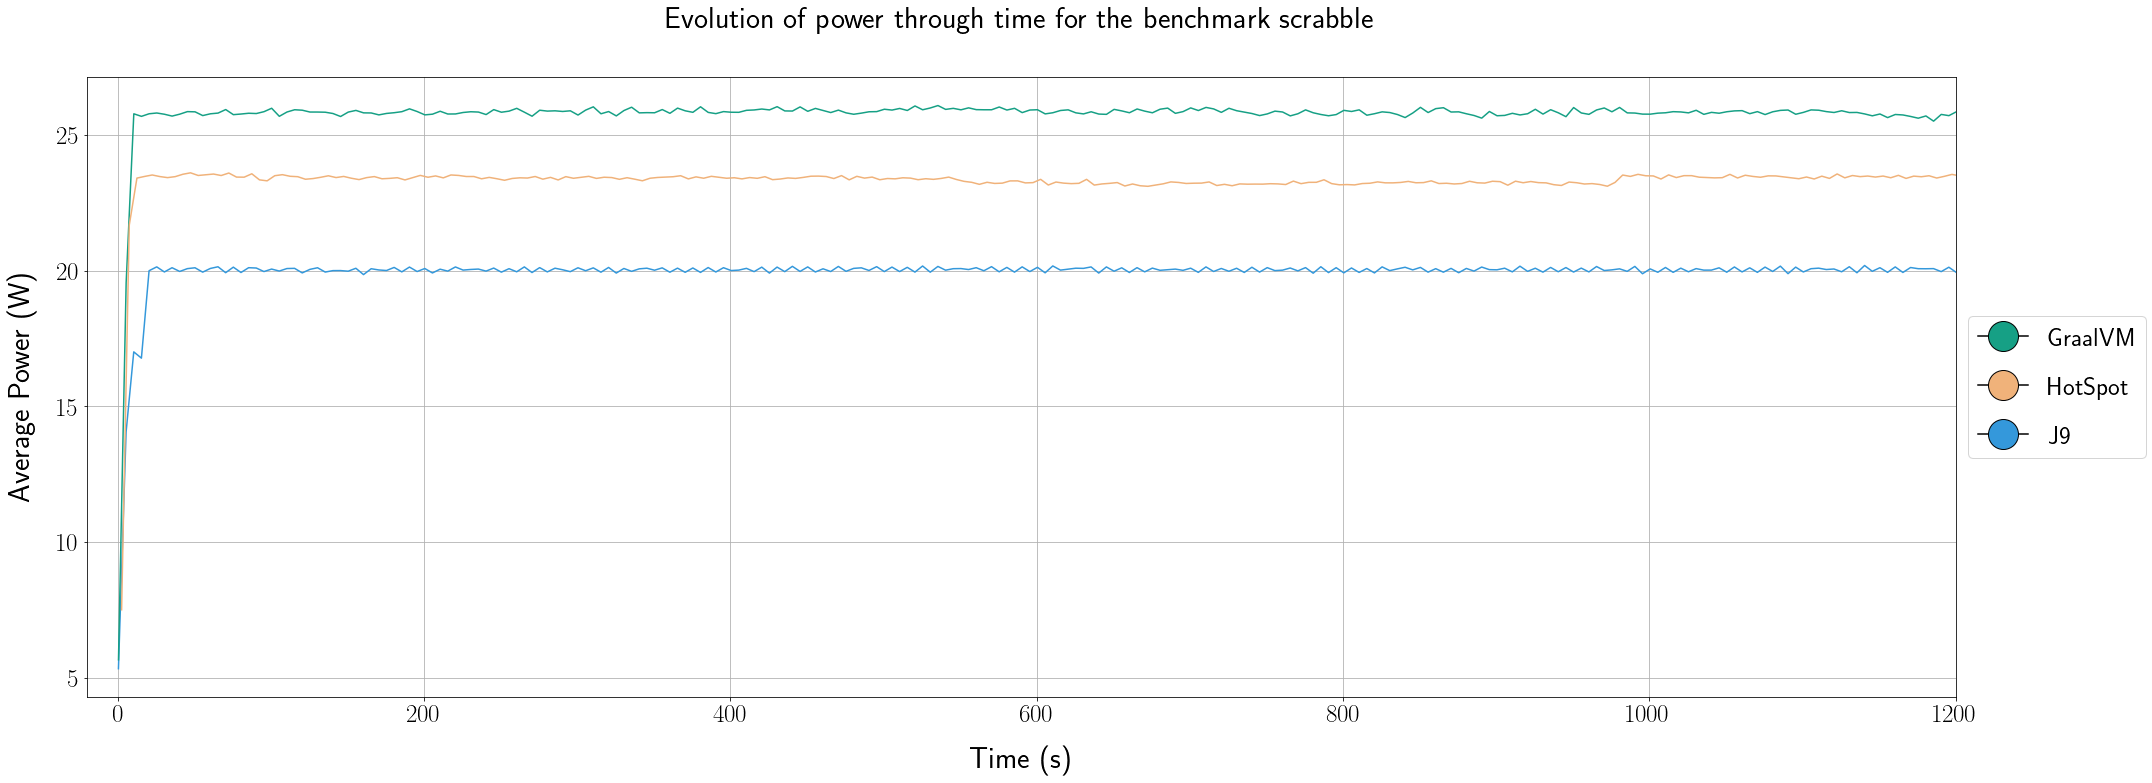

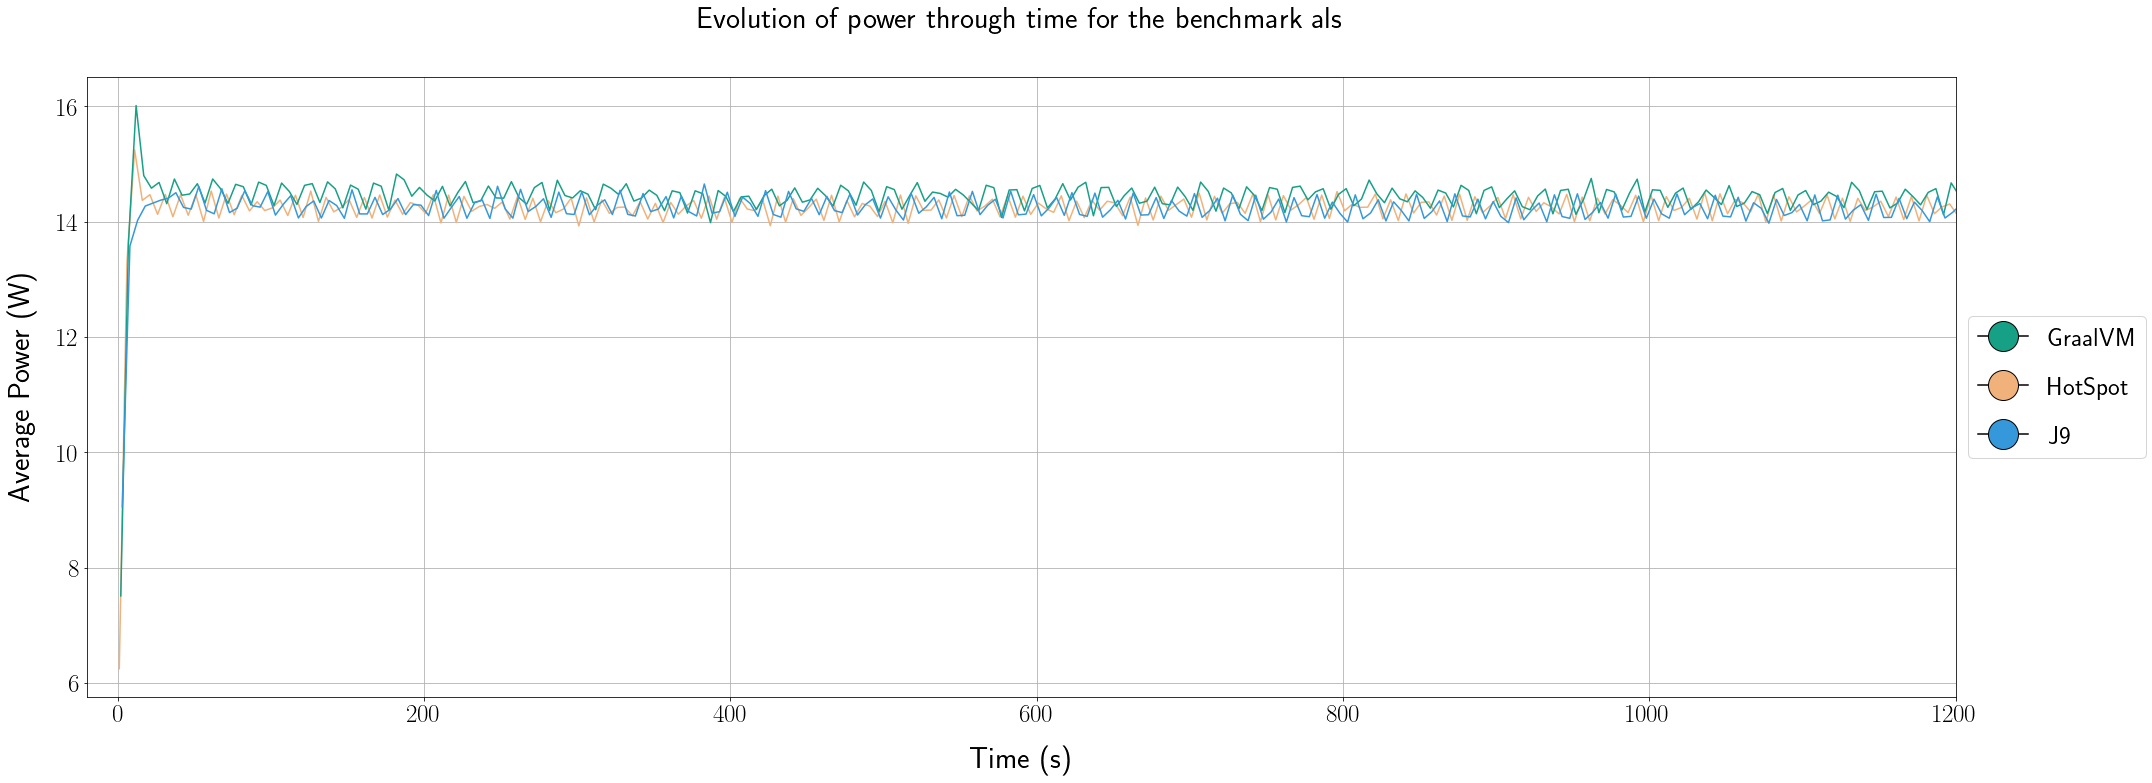

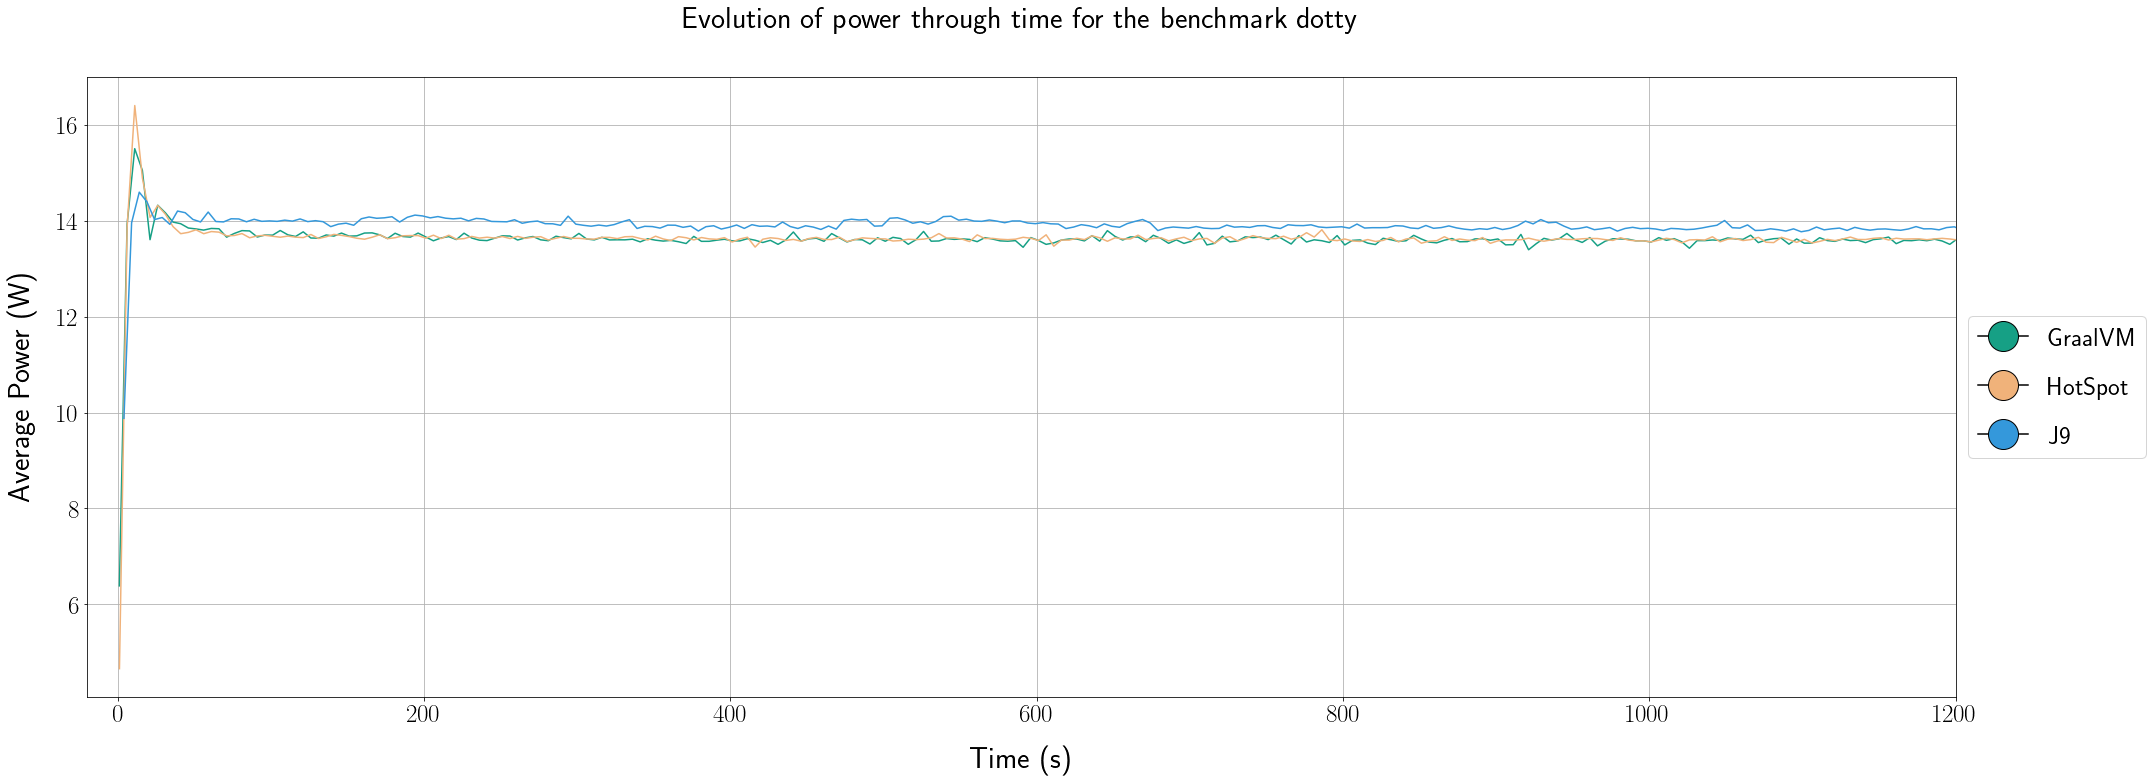

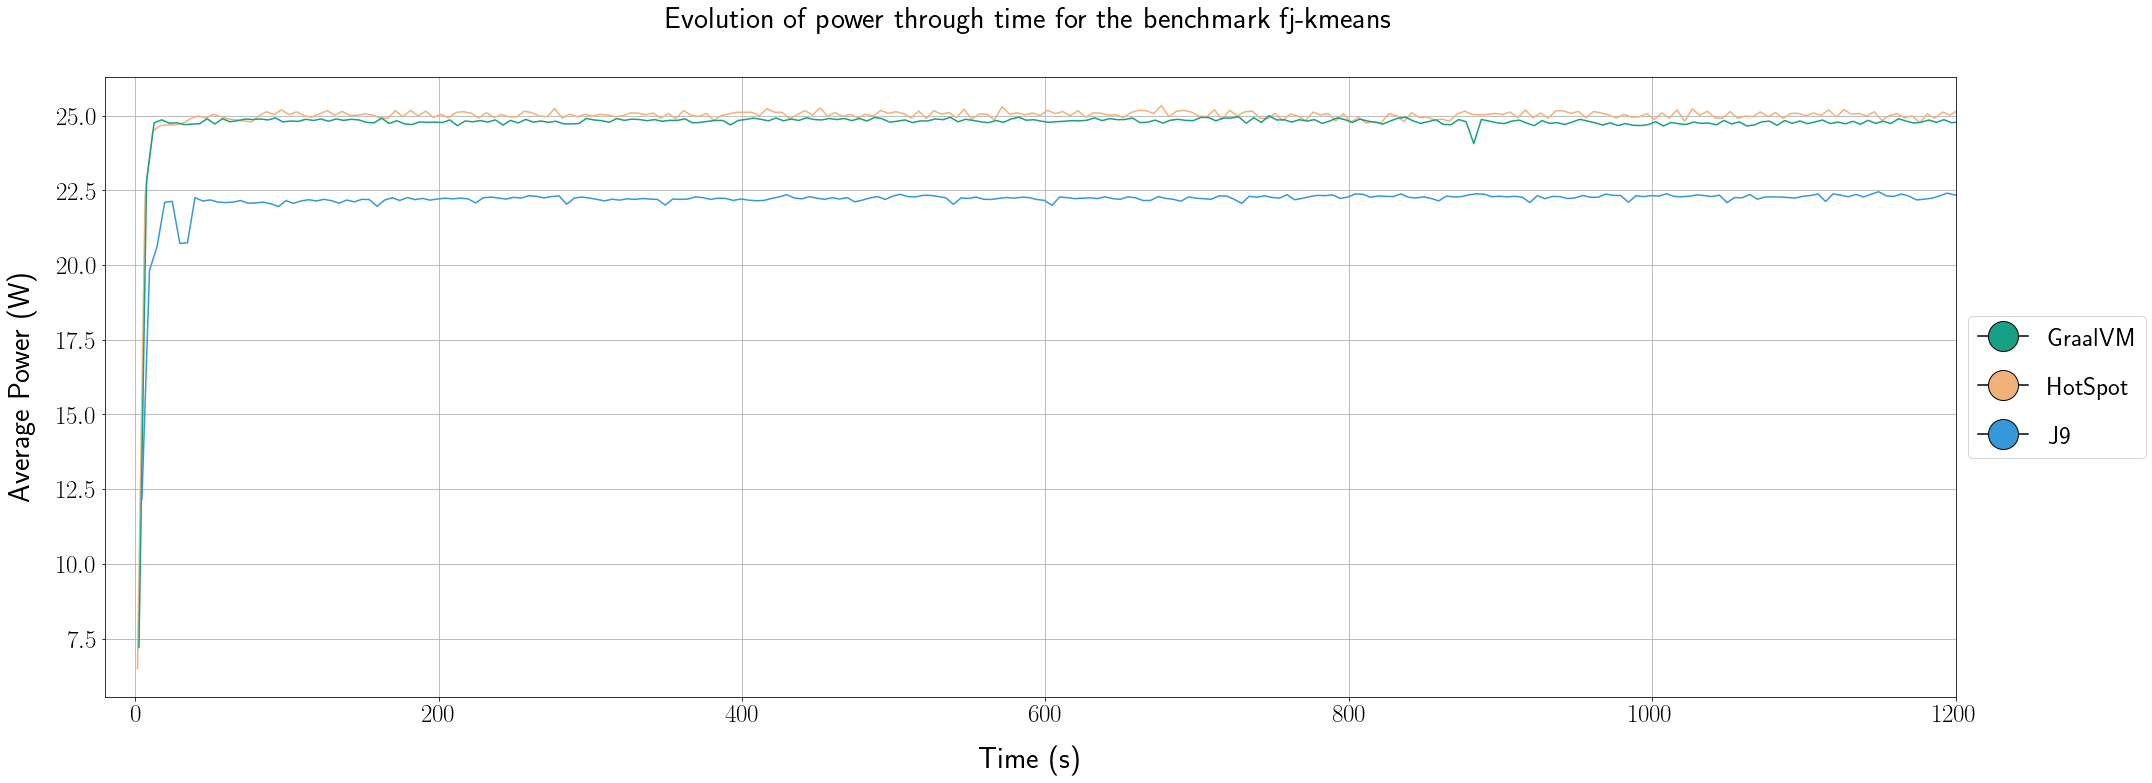

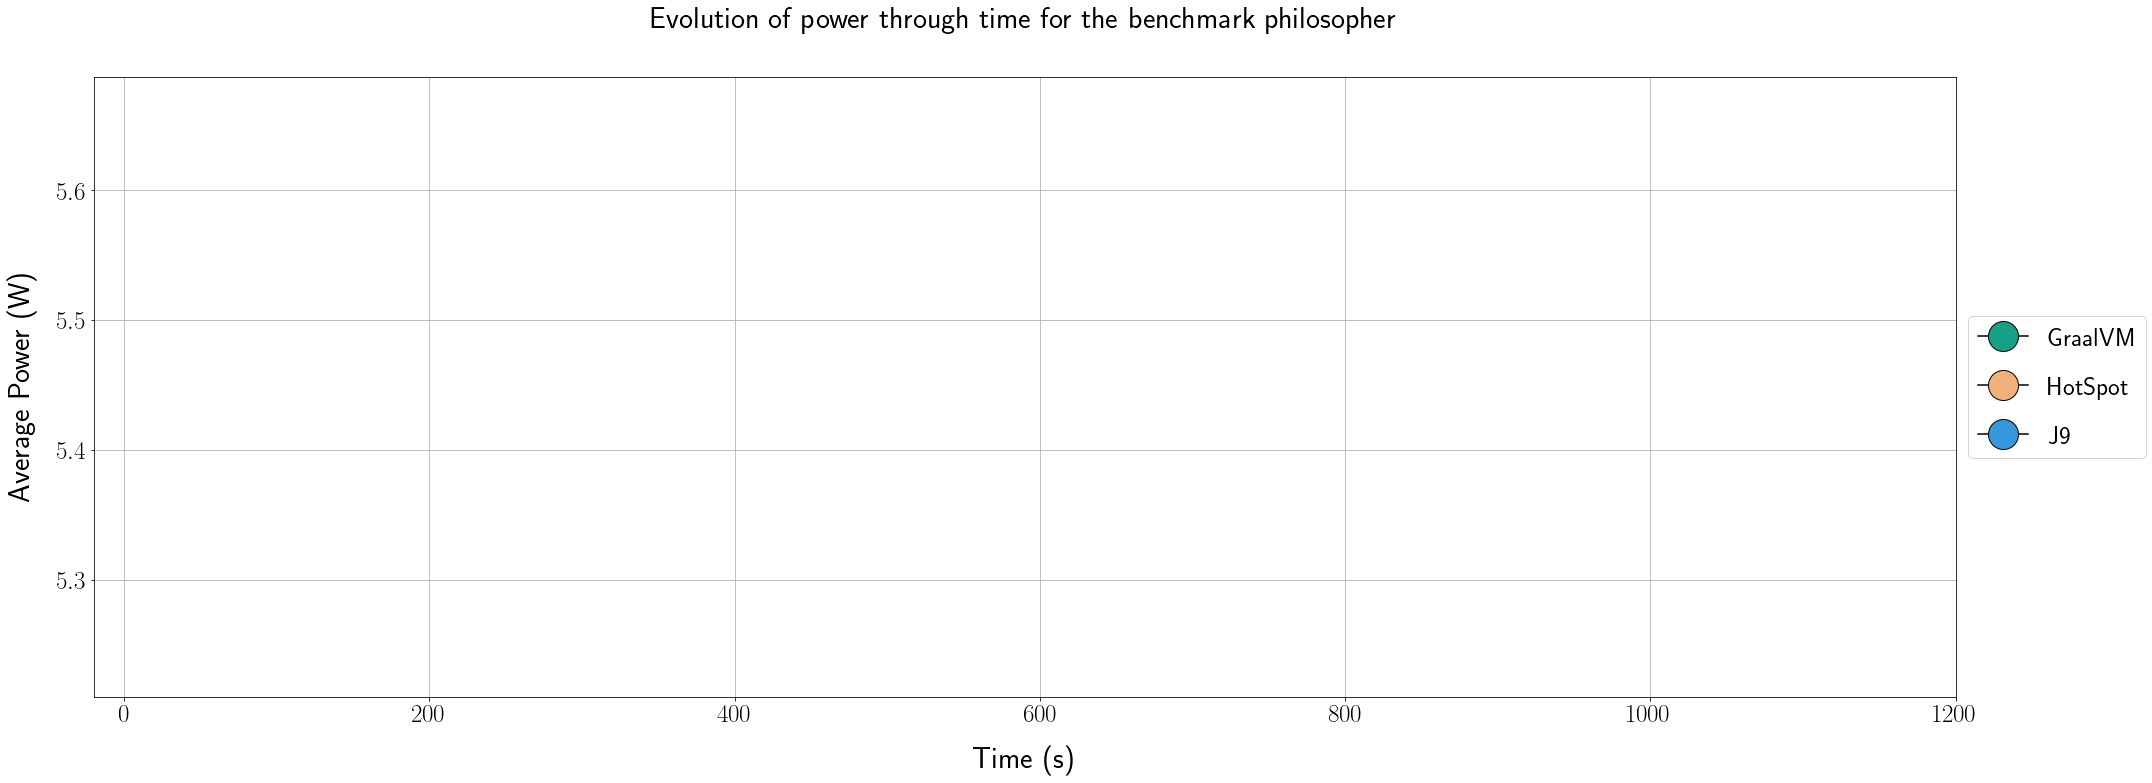

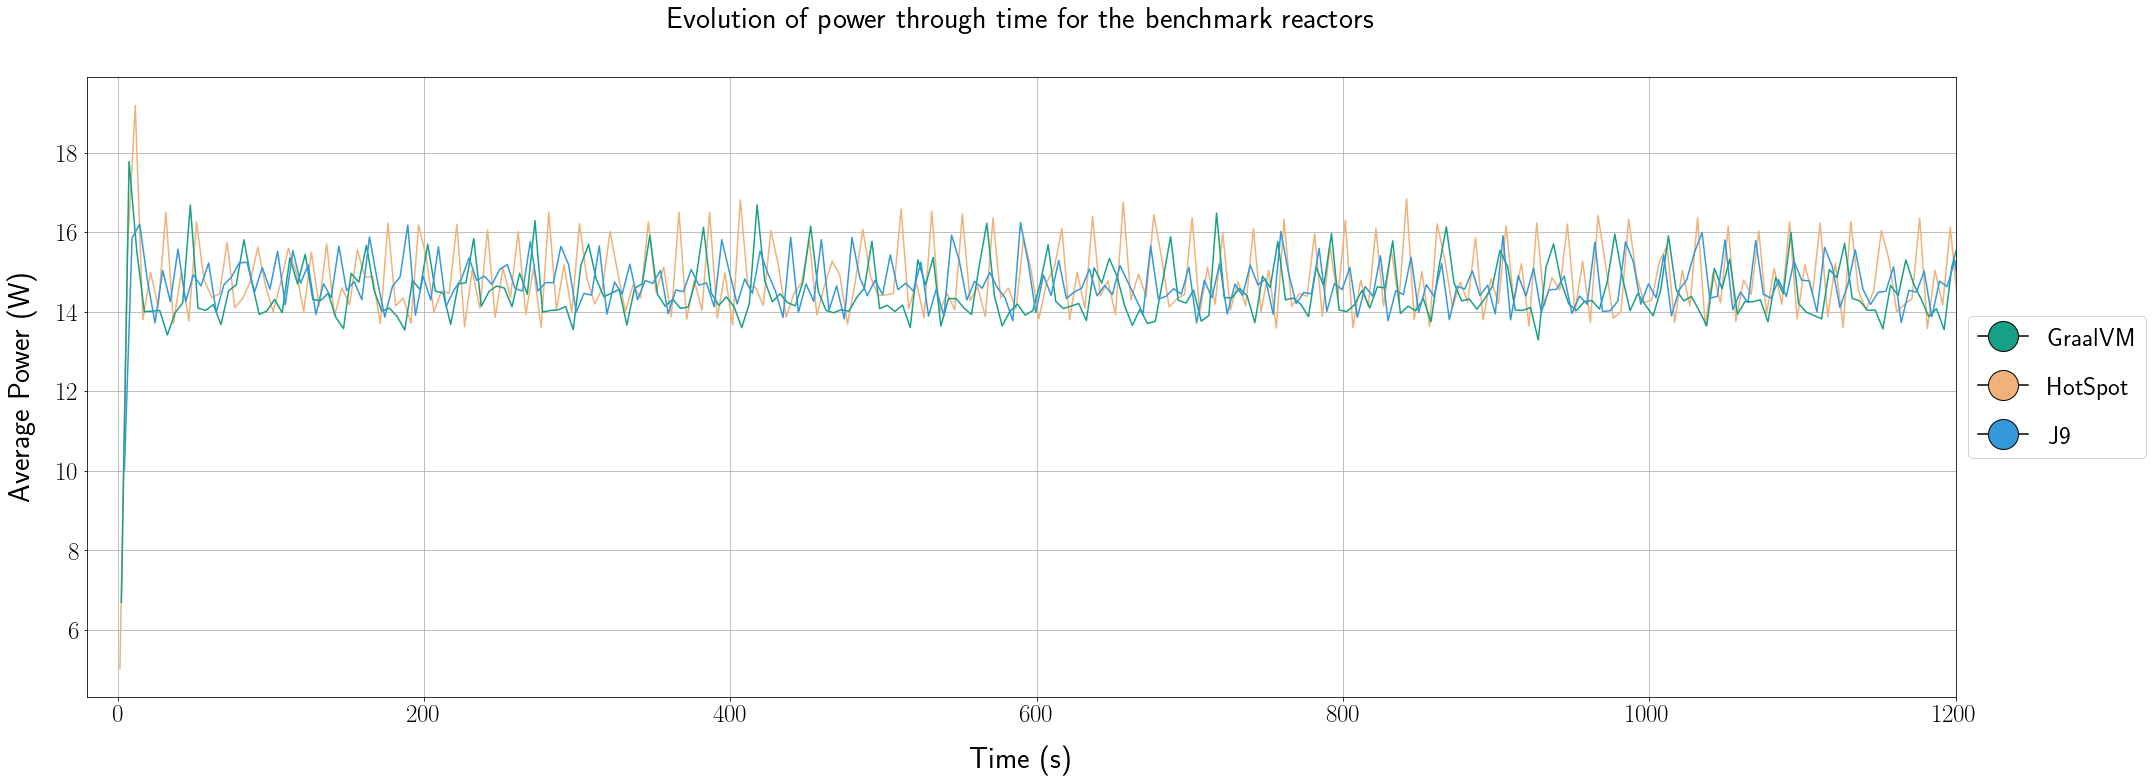

In [42]:

i=0
for bench in benchmarks : 
    fig,axes = plt.subplots(1,1, figsize=(30, 10))
    plot_powers(data.loc[data["benchmark"]==bench],axes)
    axes.set_title(f"Evolution of power through time for the benchmark {bench}"  )
    i+=1
    plt.savefig(f"results_powers/powers_{bench}.pdf",format="pdf")

